In [2]:
import pandas as pd
import mne
import numpy as np

In [3]:
#read the participants.tsv file to get subject group
participants_df = pd.read_csv('/Users/keishi/Documents/NakaguchiLab/Thai-Project/ds004504/participants.tsv', sep='\t')

def get_subject_group(subject_index):
    target_id = f"sub-{subject_index:03d}"
    group = participants_df.loc[participants_df['participant_id'] == target_id, 'Group'].values[0]
    return group

def get_subject_id(subject_group):
    id = participants_df.loc[participants_df['Group'] == subject_group, 'participant_id']
    id = id.tolist()
    #return the index for example, sub-001 is index 1
    id = [int(i.split('-')[1]) for i in id]
    return id

In [4]:
def get_data_array(subject_index):
    path = r"/Users/keishi/Documents/NakaguchiLab/Thai-Project/ds004504/derivatives/sub-{:03d}/eeg/sub-{:03d}_task-eyesclosed_eeg.set".format(subject_index, subject_index)    
    data = mne.io.read_raw_eeglab(path, preload=True)
    epochs = mne.make_fixed_length_epochs(data, duration=4.0, overlap=2)
    array = epochs.get_data()
    # shape = (n_epochs, n_channels, n_times)
    return array

In [ ]:
#Classes are A= Alzheimer ,F = Frontotemporal Dementia ,C = Control (Healthy)
AD_epochs_array = []
FTD_epochs_array = []
C_epochs_array = []
AD_epochs_array = [get_data_array(i) for i in get_subject_id('A')] #(14514, 19, 2000)
FTD_epochs_array = [get_data_array(i) for i in get_subject_id('F')] #(8262, 19, 2000)
C_epochs_array = [get_data_array(i) for i in get_subject_id('C')] #(12012, 19, 2000) 


In [6]:
AD_epochs_labels = [len(i) * [0] for i in AD_epochs_array]  # Label 0 for Alzheimer
FTD_epochs_labels = [len(i) * [1] for i in FTD_epochs_array]  # Label 1 for Frontotemporal Dementia
C_epochs_labels = [len(i) * [2] for i in C_epochs_array]  # Label 2 for Control (Healthy)

In [7]:
data_list = AD_epochs_array + FTD_epochs_array + C_epochs_array
labels_list = AD_epochs_labels + FTD_epochs_labels + C_epochs_labels
group_list = [[i] * len(j) for i,j in enumerate(data_list)]
print(len(group_list))

88


In [8]:
#we will send these three arrays to the model or futher processing
data_array = []
data_array = np.vstack(data_list)
data_array = np.moveaxis(data_array, 1, 2)
data_list = None
labels_array = np.hstack(labels_list)
group_array = np.hstack(group_list)
print(data_array.shape, labels_array.shape, group_array.shape)

(34788, 2000, 19) (34788,) (34788,)


# Data Information
Output explanation:
data_array shape: (34788, 2000, 19)
  - 34788: Total number of epochs across all subjects (88 subjects)
           Each epoch is a 4-second EEG segment with 2-second overlap
  - 2000: Number of time samples per epoch (4 seconds at 500 Hz sampling rate)
  - 19: Number of EEG channels

labels_array shape: (34788,)
  - Classification labels for each epoch
  - 0: Alzheimer's Disease (AD)
  - 1: Frontotemporal Dementia (FTD)
  - 2: Control (Healthy)

group_array shape: (34788,)
  - Subject ID for each epoch (0-87, representing 88 subjects)
  - Used for subject-level grouping in cross-validation or analysis

In [10]:
# Import the preprocessing function
import sys
sys.path.append('/Users/keishi/Documents/NakaguchiLab/Thai-Project')
from src.utils.pre_process import compute_relative_band_power

# Compute relative band power features
relative_power_features = compute_relative_band_power(data_array, fs=500, nperseg=1000)

# Verify output shape
print(f"Relative power features shape: {relative_power_features.shape}")
# Expected: (34788, 95)

# Check for any NaN or inf values
print(f"NaN values: {np.isnan(relative_power_features).sum()}")
print(f"Inf values: {np.isinf(relative_power_features).sum()}")

# Display sample statistics
print(f"\nSample statistics:")
print(f"Mean: {relative_power_features.mean():.4f}")
print(f"Std: {relative_power_features.std():.4f}")
print(f"Min: {relative_power_features.min():.4f}")
print(f"Max: {relative_power_features.max():.4f}")

# Verify that sum of powers per channel equals 1.0
print(f"\nValidation - Sum of powers per channel:")
sample_epoch = relative_power_features[0].reshape(19, 5)
channel_sums = sample_epoch.sum(axis=1)
print(f"Channel sums (should all be 1.0): {channel_sums}")
print(f"All close to 1.0: {np.allclose(channel_sums, 1.0)}")

Relative power features shape: (34788, 95)
NaN values: 0
Inf values: 0

Sample statistics:
Mean: 0.2000
Std: 0.3339
Min: 0.0001
Max: 0.9973

Validation - Sum of powers per channel:
Channel sums (should all be 1.0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
All close to 1.0: True


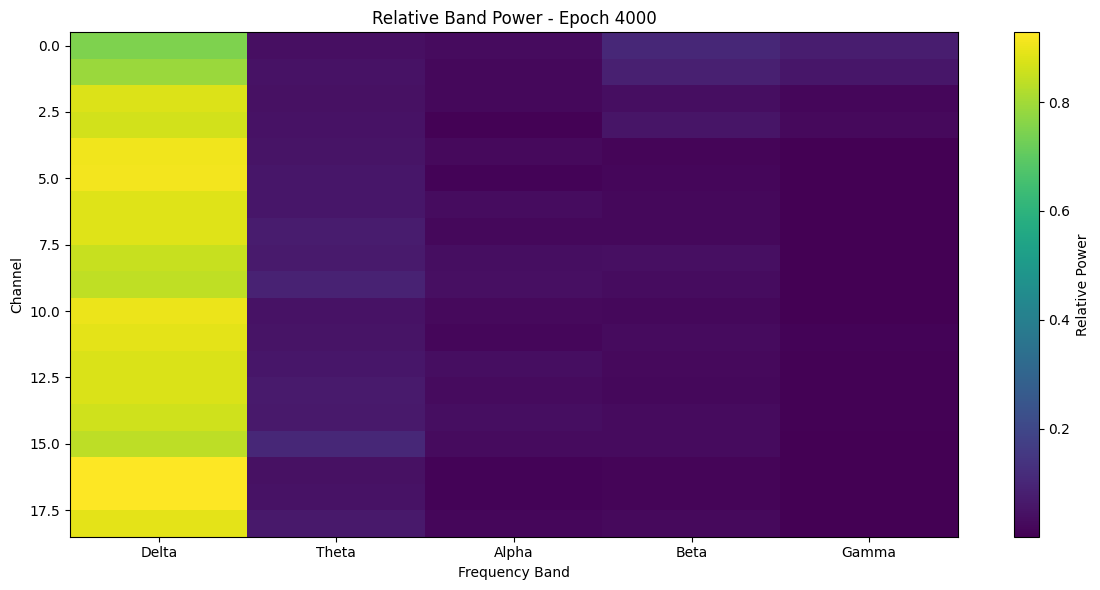

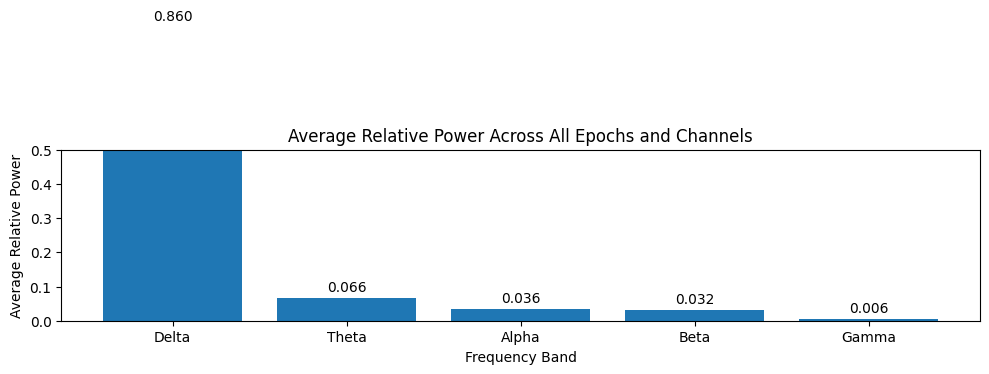

In [26]:
import matplotlib.pyplot as plt

# Visualize relative power distribution for one epoch across channels
epoch_idx = 4000
features_per_epoch = relative_power_features[epoch_idx].reshape(19, 5)

band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(features_per_epoch, aspect='auto', cmap='viridis')
ax.set_xlabel('Frequency Band')
ax.set_ylabel('Channel')
ax.set_xticks(range(5))
ax.set_xticklabels(band_names)
ax.set_title(f'Relative Band Power - Epoch {epoch_idx}')
plt.colorbar(im, label='Relative Power')
plt.tight_layout()
plt.show()

# Plot average relative power across all epochs for each band
avg_power_per_band = relative_power_features.reshape(-1, 19, 5).mean(axis=(0, 1))
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(band_names, avg_power_per_band)
ax.set_xlabel('Frequency Band')
ax.set_ylabel('Average Relative Power')
ax.set_title('Average Relative Power Across All Epochs and Channels')
ax.set_ylim([0, 0.5])
for i, v in enumerate(avg_power_per_band):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [27]:
# Get channel names from the first subject's epochs
# We'll load one subject to extract channel names
sample_path = r"/Users/keishi/Documents/NakaguchiLab/Thai-Project/ds004504/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"
sample_data = mne.io.read_raw_eeglab(sample_path, preload=True)
sample_epochs = mne.make_fixed_length_epochs(sample_data, duration=4.0, overlap=2)
channel_names = sample_epochs.ch_names

print(f"Channel names: {channel_names}")
print(f"Number of channels: {len(channel_names)}")

# If you prefer, you can also use this hardcoded list (same result):
# channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
#                  'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6',
#                  'Fz', 'Cz', 'Pz']

Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
Channel names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Number of channels: 19


In [35]:
# Reload the module to get the latest changes
import importlib
import src.utils.pre_process
importlib.reload(src.utils.pre_process)

# Import the save function
from src.utils.pre_process import save_features_to_csv

# Save features split by class
save_features_to_csv(
    features=relative_power_features,
    labels=labels_array,
    subjects=group_array,
    channel_names=channel_names,
    output_dir='../features'  # Save to project root
)

Saving features split by class label...
------------------------------------------------------------
Alzheimer's Disease (Label 0):
  - Samples: 14514
  - File: ../features/AD_features.csv
Frontotemporal Dementia (Label 1):
  - Samples: 8262
  - File: ../features/FTD_features.csv
Control (Healthy) (Label 2):
  - Samples: 12012
  - File: ../features/CN_features.csv
------------------------------------------------------------
Total samples: 34788
Columns per file: 97 (Subject_ID + Label + 95 features)
Done!


In [ ]:
# Verify the saved files
import pandas as pd

# Load AD features
ad_df = pd.read_csv('AD_features.csv')
print("=" * 70)
print("AD_features.csv:")
print("=" * 70)
print(f"Shape: {ad_df.shape}")
print(f"\nFirst 7 columns: {list(ad_df.columns[:7])}")
print(f"\nFirst few rows:")
print(ad_df.head())

# Verify column names are in correct format
print("\n" + "=" * 70)
print("Sample feature columns (first 10 features):")
print("=" * 70)
print(list(ad_df.columns[2:12]))  # Show first 10 feature columns

# Verify Subject_ID is present
assert 'Subject_ID' in ad_df.columns, "Subject_ID column missing!"
assert 'Label' in ad_df.columns, "Label column missing!"
print("\n" + "=" * 70)
print("Validation checks:")
print("=" * 70)
print("✓ Subject_ID column successfully included!")
print("✓ Label column successfully included!")
print(f"✓ Column names follow format: ChannelName_BandName")
print(f"✓ Total columns: {len(ad_df.columns)} (Subject_ID + Label + 95 features)")

# Check all three files
print("\n" + "=" * 70)
print("Summary of all files:")
print("=" * 70)
ftd_df = pd.read_csv('FTD_features.csv')
cn_df = pd.read_csv('CN_features.csv')

print(f"AD_features.csv:  {ad_df.shape[0]:,} samples, {ad_df.shape[1]} columns")
print(f"FTD_features.csv: {ftd_df.shape[0]:,} samples, {ftd_df.shape[1]} columns")
print(f"CN_features.csv:  {cn_df.shape[0]:,} samples, {cn_df.shape[1]} columns")
print(f"Total: {ad_df.shape[0] + ftd_df.shape[0] + cn_df.shape[0]:,} samples")
print("\n✓ All files created successfully!")